In [31]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
# Scaling Package
from sklearn.preprocessing import MinMaxScaler

In [32]:
train = pd.read_csv('/Users/lamprosganias/Desktop/Cybersecurity and Data Science/Β Εξάμηνο/Time-Series Analytics and Forecasting (CDS214)/Datasets/Daily-train.csv')
test = pd.read_csv('/Users/lamprosganias/Desktop/Cybersecurity and Data Science/Β Εξάμηνο/Time-Series Analytics and Forecasting (CDS214)/Datasets/Daily-test.csv')


In [33]:
train = train.iloc[0]
test = test.iloc[0]

In [34]:
train = train.dropna()  
train = train.to_frame()
test = test.dropna()  
test = test.to_frame()

In [35]:
train.reset_index(inplace=True)
test.reset_index(inplace=True)

In [36]:
header_row_train = train.iloc[0]
header_row_test = test.iloc[0]
train = pd.DataFrame(train.values[1:], columns=header_row_train)
test = pd.DataFrame(test.values[1:], columns=header_row_test)
data = pd.concat([train, test], axis=0)
data = data.reset_index(drop=True)
data = data.drop(columns=['V1'])
data


,D1
0,1017.1
1,1019.3
2,1017.0
3,1019.2
4,1018.7
...,...
1015,2066.4
1016,2067.4
1017,2071.4
1018,2083.8


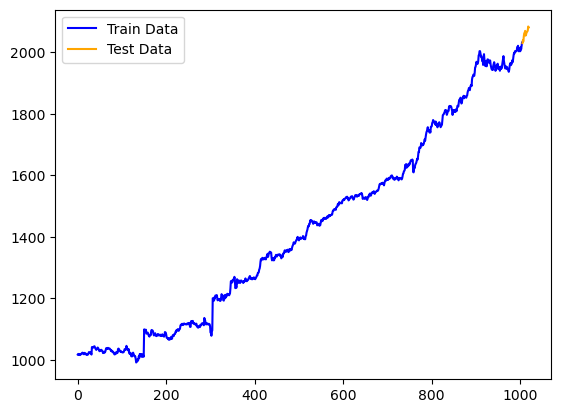

In [37]:
plt.plot(data[0:1005], color='blue', label='Train Data')
plt.plot(data[1005:], color='orange', label='Test Data')
plt.legend()
plt.show()

In [38]:
returns = data['D1'].pct_change() # Used for univariate example.

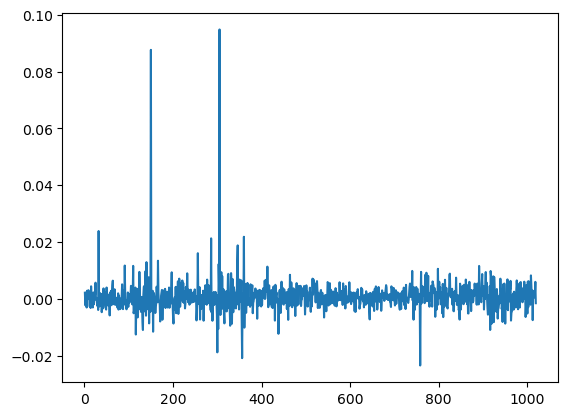

In [39]:
plt.plot(returns)

<AxesSubplot:>

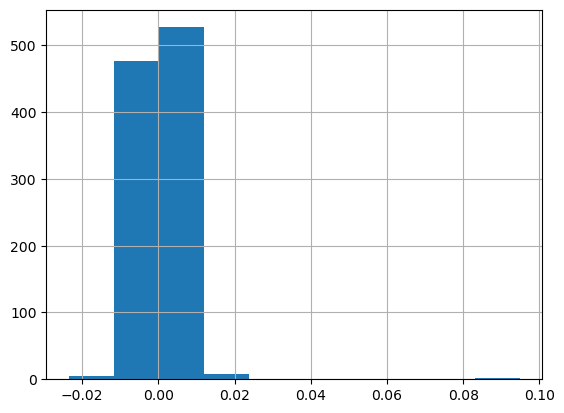

In [40]:
returns.hist()

In [41]:
# Flatten this matrix down.
npa = returns.values[:].reshape(-1,1) # Python is smart to recognize whatever dimension you need by using this parameter
print(len(npa))
# # Let's scale the data -- this helps avoid the exploding gradient issue
scale = MinMaxScaler(feature_range=(0,1)) # This is by default.
scale.fit(npa[:988])
npa = scale.transform(npa)
print(len(npa))

1020
1020


In [42]:
returns

0            NaN
1       0.002163
2      -0.002256
3       0.002163
4      -0.000491
          ...   
1015    0.001745
1016    0.000484
1017    0.001935
1018    0.005986
1019   -0.001536
Name: D1, Length: 1020, dtype: float64

In [43]:
npa

array([[       nan],
       [0.21657838],
       [0.17922945],
       ...,
       [0.21464973],
       [0.24888893],
       [0.18532089]])

In [44]:
npa[0] = 0

In [45]:
train_npa = npa[0:len(train)-1]
len(train_npa)

1005

In [46]:
test_npa = npa[len(train)-1:len(data)+1]
len(test_npa)

15

In [47]:
npa.shape[0]

1020

In [48]:
# Need the data to be in the form [sample, time steps, features (dimension of each element)]
samples = 15  # Number of samples (in past)
steps = 1  # Number of steps (in future)
X = []  # X array
Y = []  # Y array

for i in range(npa.shape[0] - samples):
    X.append(npa[i:i+samples])  # Independent Samples
    Y.append(npa[i+samples][0])  # Dependent Samples

print('Training Data: Length is', len(X[0]), ':', X[0])
print('Testing Data:',Y[0])


Training Data: Length is 15 : [[0.        ]
 [0.21657838]
 [0.17922945]
 [0.21658018]
 [0.19415283]
 [0.17258152]
 [0.22243022]
 [0.19663924]
 [0.19912865]
 [0.22402353]
 [0.21070844]
 [0.20077704]
 [0.1751747 ]
 [0.20575186]
 [0.17099471]]
Testing Data: 0.23565218710243063


In [49]:
#Reshape the data so that the inputs will be acceptable to the model.
X = np.array(X)
Y = np.array(Y)
print('Dimensions of X', X.shape, 'Dimensions of Y', Y.shape)

Dimensions of X (1005, 15, 1) Dimensions of Y (1005,)


In [50]:
threshold = npa[989:1004]
print('Threshold is', threshold)

Threshold is [[0.18817524]
 [0.20505583]
 [0.20420647]
 [0.19914211]
 [0.24931766]
 [0.19871785]
 [0.21757702]
 [0.14435879]
 [0.175995  ]
 [0.23922679]
 [0.2033376 ]
 [0.15465463]
 [0.24976241]
 [0.17356121]
 [0.25044211]]


In [51]:
# Scaling Package
from sklearn.preprocessing import MinMaxScaler

# Keras Network @ https://www.tensorflow.org/guide/keras/rnn
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Let's build the RNN
model = keras.Sequential()

# Add a RNN layer with 3 units.
model.add(layers.SimpleRNN(16,
                           activation = 'tanh',
                           use_bias=True,
                           #kernel_initializer="ones",
                           #kernel_regularizer = tf.keras.regularizers.L2(0.01),
                           #recurrent_initializer="orthogonal",
                           #activity_regularizer=tf.keras.regularizers.L2(0.01),
                           #bias_initializer="zeros",
                           #return_sequences=True,
                           input_shape=(X.shape[1], X.shape[2])))
# Add a dropout layer (penalizing more complex models) -- prevents overfitting
model.add(layers.Dropout(rate=0.2))


# Add a Dense layer with 1 units (Since we are doing a regression task.
model.add(layers.Dense(1))

# Evaluating loss function of MSE using the adam optimizer.
model.compile(loss='mse', optimizer = 'sgd')

# Print out architecture.
model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_1 (SimpleRNN)    (None, 16)                288       
                                                                 
 dropout_1 (Dropout)         (None, 16)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 305
Trainable params: 305
Non-trainable params: 0
_________________________________________________________________


In [52]:
# Fitting the data
history = model.fit(X[:989],
                    Y[:989],
                    shuffle = False, # Since this is time series data
                    epochs=500,
                    batch_size=128,
                    validation_split=0.1,
                    verbose=1) # Verbose outputs data

Epoch 1/500


7/7 [==============================] - 1s 26ms/step - loss: 0.0553 - val_loss: 0.0048
Epoch 2/500
7/7 [==============================] - 0s 5ms/step - loss: 0.0383 - val_loss: 0.0052
Epoch 3/500
7/7 [==============================] - 0s 5ms/step - loss: 0.0288 - val_loss: 0.0053
Epoch 4/500
7/7 [==============================] - 0s 6ms/step - loss: 0.0252 - val_loss: 0.0065
Epoch 5/500
7/7 [==============================] - 0s 6ms/step - loss: 0.0234 - val_loss: 0.0060
Epoch 6/500
7/7 [==============================] - 0s 5ms/step - loss: 0.0188 - val_loss: 0.0061
Epoch 7/500
7/7 [==============================] - 0s 5ms/step - loss: 0.0179 - val_loss: 0.0061
Epoch 8/500
7/7 [==============================] - 0s 5ms/step - loss: 0.0165 - val_loss: 0.0058
Epoch 9/500
7/7 [==============================] - 0s 5ms/step - loss: 0.0155 - val_loss: 0.0064
Epoch 10/500
7/7 [==============================] - 0s 5ms/step - loss: 0.0151 - val_loss: 0.0060
Epoch 11/500
7/7 [======================

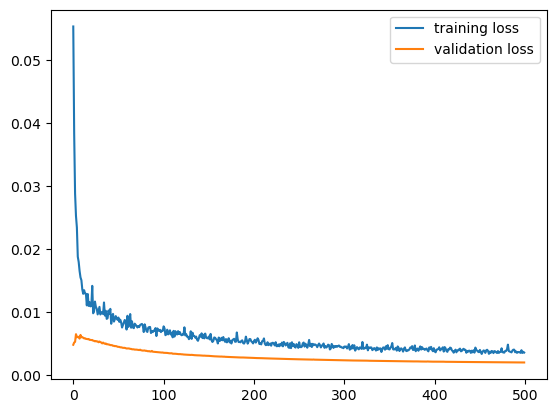

In [53]:
# Plotting the loss iteration
plt.plot(history.history['loss'], label = 'training loss')
plt.plot(history.history['val_loss'], label ='validation loss')
plt.legend()
# Note:
# if training loss >> validation loss -> Underfitting
# if training loss << validation loss -> Overfitting (i.e model is smart enough to have mapped the entire dataset..)
# Several ways to address overfitting:
# Reduce complexity of model (hidden layers, neurons, parameters input etc)
# Add dropout and tune rate
# More data :)

In [54]:
true_Y = npa[1005:1020]
pred_Y = []
print('Number of Forecasts to do: ',len(true_Y))

Number of Forecasts to do:  15


In [55]:
for i in range(1005,1020):
    p = model.predict(threshold.reshape(1,X.shape[1],1))[0,0]
    threshold = np.roll(threshold, -1)  # Shift elements to the left
    threshold[-1] = p  # Set the last element as the prediction
    pred_Y.append(p)
    print(p)

1/1 [==============================] - 0s 152ms/step
0.20295511
1/1 [==============================] - 0s 19ms/step
0.23056346
1/1 [==============================] - 0s 18ms/step
0.20742181
1/1 [==============================] - 0s 18ms/step
0.20787258
1/1 [==============================] - 0s 19ms/step
0.20611969
1/1 [==============================] - 0s 19ms/step
0.20565812
1/1 [==============================] - 0s 18ms/step
0.21794093
1/1 [==============================] - 0s 16ms/step
0.20768565
1/1 [==============================] - 0s 16ms/step
0.21103364
1/1 [==============================] - 0s 15ms/step
0.2008007
1/1 [==============================] - 0s 15ms/step
0.20021416
1/1 [==============================] - 0s 14ms/step
0.2007472
1/1 [==============================] - 0s 15ms/step
0.20082295
1/1 [==============================] - 0s 15ms/step
0.20589948
1/1 [==============================] - 0s 22ms/step
0.20247291


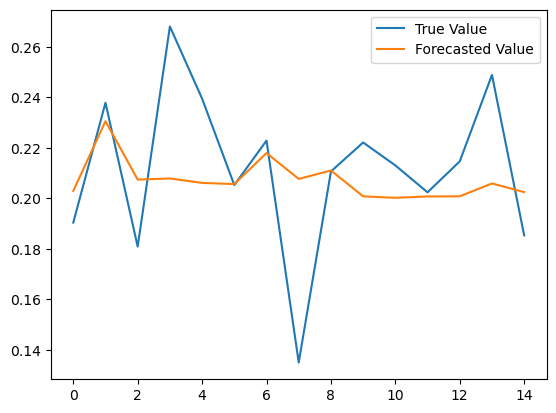

In [56]:
plt.plot(true_Y, label = 'True Value')
plt.plot(pred_Y, label = 'Forecasted Value')
plt.legend()
# Model just copied the same value over and over again. Hence, model is not very robust.
# It's just predicting the mean.

In [57]:
true_Y

array([[0.19039515],
       [0.23785365],
       [0.18089277],
       [0.26806629],
       [0.23948701],
       [0.20526678],
       [0.22287158],
       [0.13500293],
       [0.21064199],
       [0.22212755],
       [0.21304745],
       [0.20238846],
       [0.21464973],
       [0.24888893],
       [0.18532089]])

In [58]:
pred_Y

[0.20295511,
 0.23056346,
 0.20742181,
 0.20787258,
 0.20611969,
 0.20565812,
 0.21794093,
 0.20768565,
 0.21103364,
 0.2008007,
 0.20021416,
 0.2007472,
 0.20082295,
 0.20589948,
 0.20247291]

In [59]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
# Calculate mean squared error (MSE)
mse = mean_squared_error(true_Y, pred_Y)

# Calculate mean absolute error (MAE)
mae = mean_absolute_error(true_Y, pred_Y)

# Print the evaluation metrics
print("Mean Squared Error (MSE):", mse)
print("Mean Absolute Error (MAE):", mae)

Mean Squared Error (MSE): 0.0009276287501586062
Mean Absolute Error (MAE): 0.021873748102065337
